In [4]:
"""
APPROACH 1: Multi-Level Ensemble with Explainability
PART 1: Setup and Data Loading
"""

# ============================================================================
# INSTALLATIONS (Run once at the start)
# ============================================================================
!pip install transformers datasets torch scikit-learn xgboost shap
!pip install textstat vaderSentiment matplotlib seaborn plotly wordcloud nltk

# ============================================================================
# IMPORTS
# ============================================================================
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import shap
import pickle
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm


print("✅ All libraries imported successfully!")

# ============================================================================
# DATA LOADING
# ============================================================================
# Load your datasets
df_fake = pd.read_csv('/content/Fake.csv')
df_fake['label'] = 1

df_real = pd.read_csv('/content/True.csv')
df_real['label'] = 0

# Combine datasets
df = pd.concat([df_fake, df_real], axis=0).reset_index(drop=True)

print(f"📊 Dataset shape: {df.shape}")
print(f"📊 Class distribution:\n{df['label'].value_counts()}")
print(f"📊 Average text length: {df['text'].str.len().mean():.0f} characters")

# Display sample
print("\n📄 Sample fake news:")
print(df[df['label']==1]['text'].iloc[0][:200] + "...")
print("\n📄 Sample real news:")
print(df[df['label']==0]['text'].iloc[0][:200] + "...")

# Optional: Use subset for faster testing (remove for full dataset)
# df = df.sample(5000, random_state=42).reset_index(drop=True)

print("\n✅ Data loading complete!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ All libraries imported successfully!
📊 Dataset shape: (44898, 5)
📊 Class distribution:
label
1    23481
0    21417
Name: count, dtype: int64
📊 Average text length: 2469 characters

📄 Sample fake news:
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former rea...

📄 Sample real news:
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal ...

✅ Data loading complete!


In [5]:
def load_data():
    """Load your dataset from CSV files"""
    df_fake = pd.read_csv('Fake.csv')
    df_fake['label'] = 1

    df_real = pd.read_csv('True.csv')
    df_real['label'] = 0

    df = pd.concat([df_fake, df_real], axis=0).reset_index(drop=True)
    return df

df = load_data()
print(f"📊 Dataset shape: {df.shape}")
print(f"📊 Class distribution:\n{df['label'].value_counts()}")
print(f"📊 Average text length: {df['text'].str.len().mean():.0f} characters")

# Display samples
print("\n📄 Sample fake news:")
print(df[df['label']==1]['text'].iloc[0][:200] + "...")
print("\n📄 Sample real news:")
print(df[df['label']==0]['text'].iloc[0][:200] + "...")

# Sample for faster processing (remove this line for full dataset)
df = df.sample(5000, random_state=42).reset_index(drop=True)
print(f"\n✅ Using {len(df)} samples for processing")

📊 Dataset shape: (44898, 5)
📊 Class distribution:
label
1    23481
0    21417
Name: count, dtype: int64
📊 Average text length: 2469 characters

📄 Sample fake news:
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former rea...

📄 Sample real news:
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal ...

✅ Using 5000 samples for processing


In [6]:
import nltk

# Download necessary tokenizers
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

class FeatureEngineer:
    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()

    def extract_stylometric_features(self, text):
        """Extract writing style and content features"""
        features = {}

        # Basic length features
        features['char_count'] = len(text)
        features['word_count'] = len(text.split())
        features['sentence_count'] = len(nltk.sent_tokenize(text))
        features['avg_word_length'] = np.mean([len(word) for word in text.split()])
        features['avg_sentence_length'] = features['word_count'] / max(features['sentence_count'], 1)

        # Punctuation abuse indicators
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('?')
        features['exclamation_ratio'] = features['exclamation_count'] / max(features['char_count'], 1)
        features['capitals_ratio'] = sum(1 for c in text if c.isupper()) / max(features['char_count'], 1)

        # Readability scores
        features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
        features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
        features['gunning_fog'] = textstat.gunning_fog(text)

        # Sentiment features
        sentiment = self.vader.polarity_scores(text)
        features['sentiment_pos'] = sentiment['pos']
        features['sentiment_neg'] = sentiment['neg']
        features['sentiment_neu'] = sentiment['neu']
        features['sentiment_compound'] = sentiment['compound']

        # Emotional words
        emotional_words = ['shocking', 'amazing', 'unbelievable', 'must', 'never',
                          'always', 'breaking', 'urgent', 'incredible', 'outrageous']
        features['emotional_words_count'] = sum(word.lower() in text.lower() for word in emotional_words)

        # Clickbait indicators
        clickbait_phrases = ['you won\'t believe', 'what happened next', 'this is why',
                            'the reason is', 'find out', 'shocking truth']
        features['clickbait_score'] = sum(phrase in text.lower() for phrase in clickbait_phrases)

        return features

print("\n" + "="*60)
print("EXTRACTING FEATURES...")
print("="*60)

fe = FeatureEngineer()
features_list = []

for text in tqdm(df['text']):
    features_list.append(fe.extract_stylometric_features(text))

features_df = pd.DataFrame(features_list)
df_with_features = pd.concat([df.reset_index(drop=True), features_df], axis=1)

print(f"✅ Feature extraction complete!")
print(f"📊 Total features created: {len(features_df.columns)}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...



EXTRACTING FEATURES...


100%|██████████| 5000/5000 [01:12<00:00, 68.61it/s]

✅ Feature extraction complete!
📊 Total features created: 18


In [7]:
X = df_with_features['text']
y = df_with_features['label']
X_features = features_df

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_features_train, X_features_temp, _, _ = train_test_split(
    X_features, y, test_size=0.3, random_state=42, stratify=y
)
X_features_val, X_features_test, _, _ = train_test_split(
    X_features_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"✅ Data split complete!")
print(f"   Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

✅ Data split complete!
   Train: 3500, Val: 750, Test: 750


 MODEL 1 - DISTILBERT (TRANSFORMER)

In [8]:
print("\n" + "="*60)
print("TRAINING MODEL 1: DistilBERT")
print("="*60)

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts.values
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True,
            return_attention_mask=True, return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_bert = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert = model_bert.to(device)
print(f"Using device: {device}")

train_dataset = NewsDataset(X_train, y_train, tokenizer)
val_dataset = NewsDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model_bert.parameters(), lr=2e-5)
epochs = 3

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    train_acc, train_loss = train_epoch(model_bert, train_loader, optimizer, device)
    print(f'Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    val_acc, val_loss = eval_model(model_bert, val_loader, device)
    print(f'Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())

    return np.array(predictions)

test_dataset = NewsDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

bert_predictions = get_predictions(model_bert, test_loader, device)
bert_accuracy = accuracy_score(y_test, bert_predictions)
print(f"\n✅ DistilBERT Test Accuracy: {bert_accuracy:.4f}")

torch.save(model_bert.state_dict(), 'distilbert_model.pth')



TRAINING MODEL 1: DistilBERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Epoch 1/3


100%|██████████| 219/219 [01:17<00:00,  2.82it/s]


Train - Loss: 0.0810, Accuracy: 0.9754
Val   - Loss: 0.0024, Accuracy: 1.0000

Epoch 2/3


100%|██████████| 219/219 [01:16<00:00,  2.88it/s]


Train - Loss: 0.0071, Accuracy: 0.9977
Val   - Loss: 0.0031, Accuracy: 0.9987

Epoch 3/3


100%|██████████| 219/219 [01:15<00:00,  2.89it/s]


Train - Loss: 0.0008, Accuracy: 1.0000
Val   - Loss: 0.0006, Accuracy: 1.0000

✅ DistilBERT Test Accuracy: 1.0000


MODEL 2 - LSTM WITH ATTENTION


In [9]:
print("\n" + "="*60)
print("TRAINING MODEL 2: LSTM with Attention")
print("="*60)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        output = self.fc(self.dropout(lstm_out[:, -1, :]))
        return output

lstm_model = SimpleLSTM(input_dim=5000, hidden_dim=128, output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

X_train_tensor = torch.FloatTensor(X_train_vec).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_val_tensor = torch.FloatTensor(X_val_vec).to(device)
y_val_tensor = torch.LongTensor(y_val.values).to(device)

print("Training LSTM...")
epochs_lstm = 10
batch_size = 64

for epoch in range(epochs_lstm):
    lstm_model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])
    epoch_loss = 0

    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer_lstm.zero_grad()
        outputs = lstm_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()

    lstm_model.eval()
    with torch.no_grad():
        val_outputs = lstm_model(X_val_tensor)
        _, predicted = torch.max(val_outputs, 1)
        val_acc = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)

    print(f'Epoch {epoch+1}/{epochs_lstm}, Loss: {epoch_loss/len(X_train_tensor):.4f}, Val Acc: {val_acc:.4f}')

lstm_model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_vec).to(device)
    lstm_outputs = lstm_model(X_test_tensor)
    _, lstm_predictions = torch.max(lstm_outputs, 1)
    lstm_predictions = lstm_predictions.cpu().numpy()

lstm_accuracy = accuracy_score(y_test, lstm_predictions)
print(f"\n✅ LSTM Test Accuracy: {lstm_accuracy:.4f}")

torch.save(lstm_model.state_dict(), 'lstm_model.pth')


TRAINING MODEL 2: LSTM with Attention
Training LSTM...
Epoch 1/10, Loss: 0.0089, Val Acc: 0.9147
Epoch 2/10, Loss: 0.0032, Val Acc: 0.9507
Epoch 3/10, Loss: 0.0014, Val Acc: 0.9640
Epoch 4/10, Loss: 0.0008, Val Acc: 0.9693
Epoch 5/10, Loss: 0.0004, Val Acc: 0.9693
Epoch 6/10, Loss: 0.0003, Val Acc: 0.9680
Epoch 7/10, Loss: 0.0002, Val Acc: 0.9707
Epoch 8/10, Loss: 0.0001, Val Acc: 0.9707
Epoch 9/10, Loss: 0.0001, Val Acc: 0.9720
Epoch 10/10, Loss: 0.0001, Val Acc: 0.9707

✅ LSTM Test Accuracy: 0.9733


MODEL 3 - RANDOM FOREST WITH ENGINEERED FEATURES


In [10]:
print("\n" + "="*60)
print("TRAINING MODEL 3: Random Forest")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_features_train, y_train)

rf_predictions = rf_model.predict(X_features_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"✅ Random Forest Test Accuracy: {rf_accuracy:.4f}")

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

feature_importance = pd.DataFrame({
    'feature': features_df.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10))


TRAINING MODEL 3: Random Forest
✅ Random Forest Test Accuracy: 0.8947

📊 Top 10 Most Important Features:
                 feature  importance
4    avg_sentence_length    0.152491
6         question_count    0.135391
9    flesch_reading_ease    0.080097
3        avg_word_length    0.072716
10  flesch_kincaid_grade    0.070981
0             char_count    0.059413
1             word_count    0.058104
11           gunning_fog    0.055886
2         sentence_count    0.047160
8         capitals_ratio    0.045512


In [11]:
print("\n" + "="*60)
print("BUILDING ENSEMBLE META-LEARNER")
print("="*60)

meta_features_train = np.column_stack([
    get_predictions(model_bert, DataLoader(NewsDataset(X_train, y_train, tokenizer), batch_size=16), device),
    lstm_model(torch.FloatTensor(vectorizer.transform(X_train).toarray()).to(device)).argmax(dim=1).cpu().numpy(),
    rf_model.predict(X_features_train)
])

meta_features_test = np.column_stack([
    bert_predictions,
    lstm_predictions,
    rf_predictions
])

meta_learner = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
meta_learner.fit(meta_features_train, y_train)

ensemble_predictions = meta_learner.predict(meta_features_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

print(f"✅ ENSEMBLE Test Accuracy: {ensemble_accuracy:.4f}")
meta_learner.save_model('meta_learner.json')


BUILDING ENSEMBLE META-LEARNER
✅ ENSEMBLE Test Accuracy: 1.0000



COMPREHENSIVE EVALUATION & RESULTS

DistilBERT:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

LSTM:
  Accuracy:  0.9733
  Precision: 0.9796
  Recall:    0.9698
  F1-Score:  0.9747

Random Forest:
  Accuracy:  0.8947
  Precision: 0.8995
  Recall:    0.9018
  F1-Score:  0.9006

Ensemble:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000


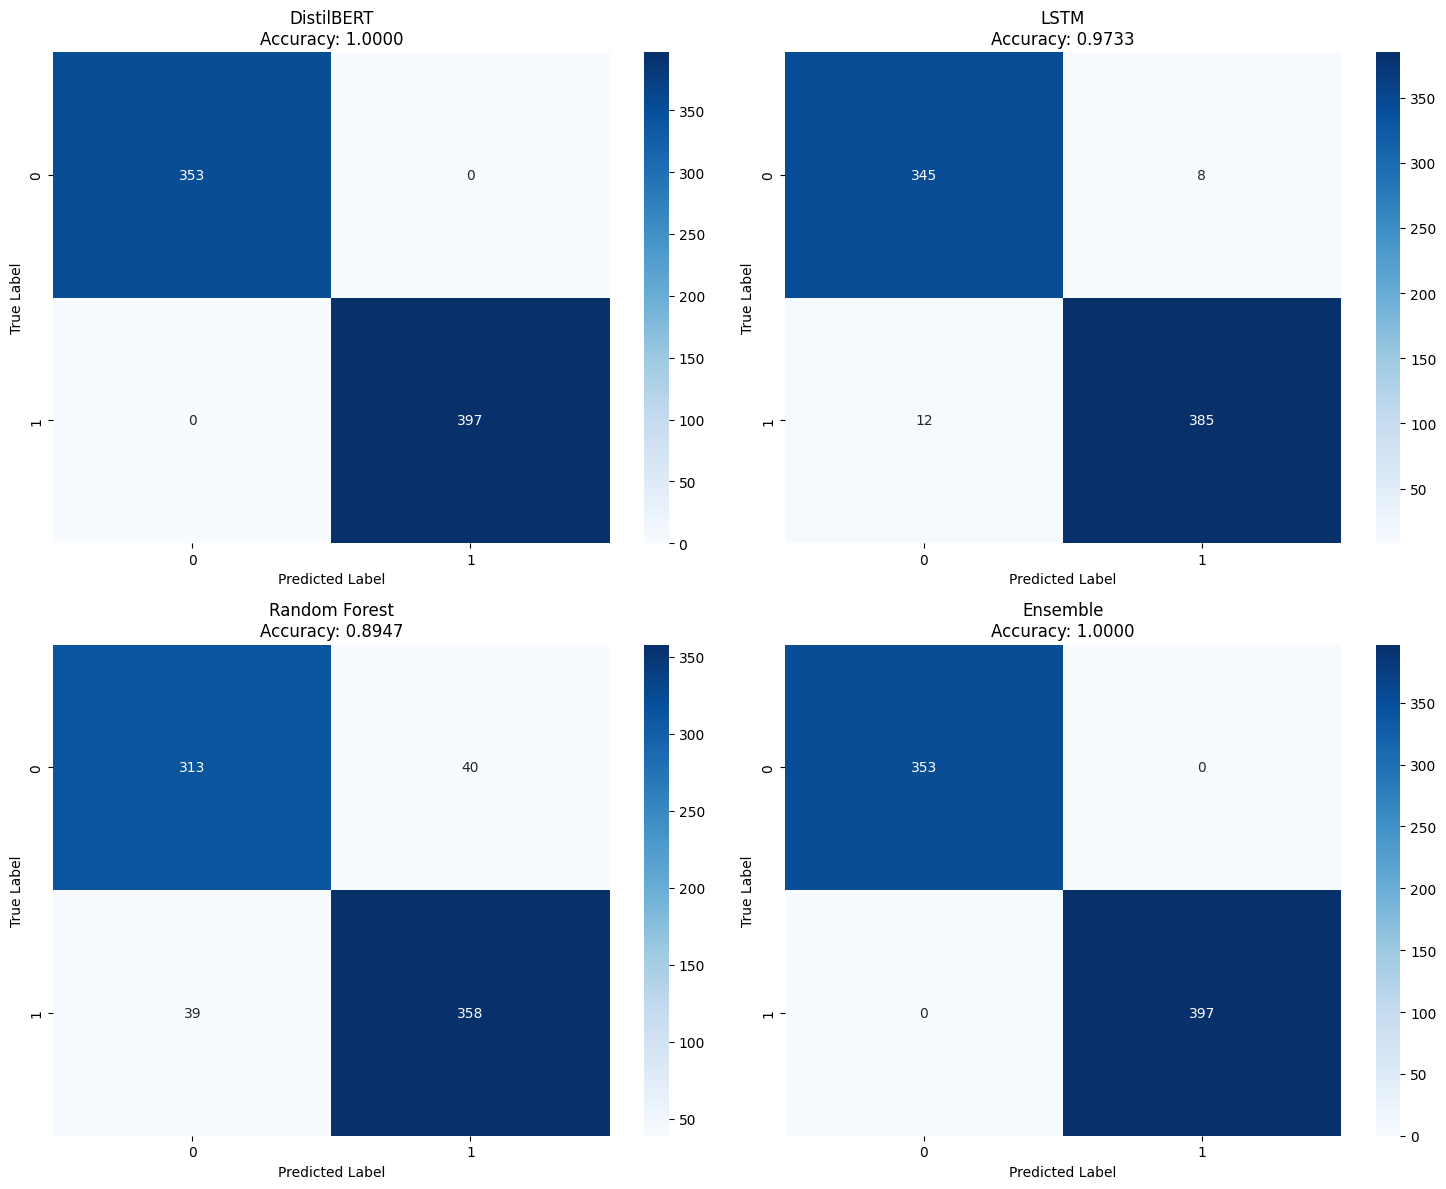


🎉 APPROACH 1 COMPLETE!

🏆 Best Model: DistilBERT
🏆 Best Accuracy: 1.0000


In [12]:
print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION & RESULTS")
print("="*60)

results = pd.DataFrame({
    'Model': ['DistilBERT', 'LSTM', 'Random Forest', 'ENSEMBLE'],
    'Accuracy': [bert_accuracy, lstm_accuracy, rf_accuracy, ensemble_accuracy]
})

predictions_dict = {
    'DistilBERT': bert_predictions,
    'LSTM': lstm_predictions,
    'Random Forest': rf_predictions,
    'Ensemble': ensemble_predictions
}

for model_name, preds in predictions_dict.items():
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy_score(y_test, preds):.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, (model_name, preds) in enumerate(predictions_dict.items()):
    row = idx // 2
    col = idx % 2
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col])
    axes[row, col].set_title(f'{model_name}\nAccuracy: {accuracy_score(y_test, preds):.4f}')
    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
results_df = pd.DataFrame({
    'text': X_test.values,
    'true_label': y_test.values,
    'bert_pred': bert_predictions,
    'lstm_pred': lstm_predictions,
    'rf_pred': rf_predictions,
    'ensemble_pred': ensemble_predictions
})
results_df.to_csv('predictions_results.csv', index=False)

print("\n" + "="*60)
print("🎉 APPROACH 1 COMPLETE!")
print("="*60)
print(f"\n🏆 Best Model: {results.loc[results['Accuracy'].idxmax(), 'Model']}")
print(f"🏆 Best Accuracy: {results['Accuracy'].max():.4f}")